In [2]:
import sys
import shutil
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications import ResNet50
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import random

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# 데이터 디렉토리 설정
data_dir = '/content/drive/MyDrive/archive/Dataset_BUSI_with_GT'

In [5]:
# 이미지 크기 및 배치 크기 설정
img_size = (224, 224)  # 원하는 이미지 크기로 변경
batch_size = 16

# 이미지 데이터를 불러와서 전처리
data_generator = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_data = data_generator.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_data = data_generator.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1263 images belonging to 3 classes.
Found 315 images belonging to 3 classes.


In [7]:
# 모델 아키텍처 선택
model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# 모델 뒷부분 추가 (분류기)
x = model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(3, activation='softmax')(x)

model = keras.models.Model(inputs=model.input, outputs=predictions)

# 모델 컴파일
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
# 모델 학습
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // batch_size,
    epochs=10,  # 원하는 에포크 수로 조정
    validation_data=validation_data,
    validation_steps=validation_data.samples // batch_size
)


Epoch 1/10
78/78 [==============================] - 654s 8s/step - loss: 0.9074 - accuracy: 0.6985 - val_loss: 9.7522 - val_accuracy: 0.2599
Epoch 2/10
78/78 [==============================] - 16s 207ms/step - loss: 0.4928 - accuracy: 0.8091 - val_loss: 9.5982 - val_accuracy: 0.1743
Epoch 3/10
78/78 [==============================] - 17s 210ms/step - loss: 0.4085 - accuracy: 0.8396 - val_loss: 4.0131 - val_accuracy: 0.1711
Epoch 4/10
78/78 [==============================] - 17s 213ms/step - loss: 0.3804 - accuracy: 0.8549 - val_loss: 1.0698 - val_accuracy: 0.5592
Epoch 5/10
78/78 [==============================] - 17s 217ms/step - loss: 0.3302 - accuracy: 0.8685 - val_loss: 3.9705 - val_accuracy: 0.1743
Epoch 6/10
78/78 [==============================] - 17s 218ms/step - loss: 0.3348 - accuracy: 0.8749 - val_loss: 1.5024 - val_accuracy: 0.1809
Epoch 7/10
78/78 [==============================] - 18s 224ms/step - loss: 0.2500 - accuracy: 0.9078 - val_loss: 2.1136 - val_accuracy: 0.1941
E

In [9]:
# 모델 평가
Y_pred = model.predict(validation_data)
y_val = validation_data.classes
accuracy = accuracy_score(y_val, np.argmax(Y_pred, axis=1))
print('Model Accuracy Score:', accuracy)

20/20 [==============================] - 9s 409ms/step
Model Accuracy Score: 0.33650793650793653


<Axes: >

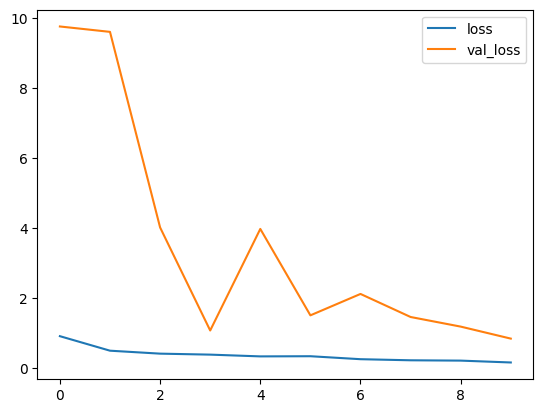

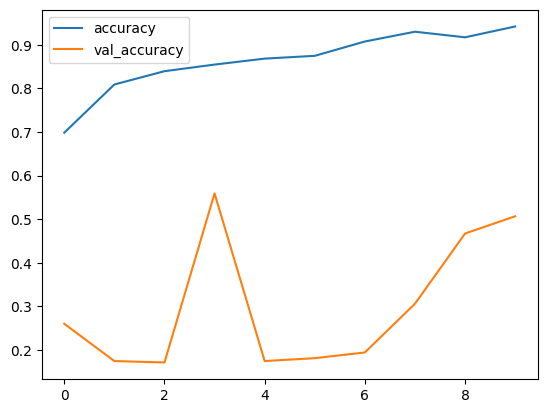

In [10]:
# 시각화
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

In [11]:
# 혼동 행렬
confusion = confusion_matrix(y_val, np.argmax(Y_pred, axis=1))
print('Confusion Matrix:\n', confusion)

Confusion Matrix:
 [[84 17 77]
 [28  5 51]
 [29  7 17]]


In [12]:
from sklearn.preprocessing import label_binarize

# y_val을 이진 형태로 변환 (OvR 전략)
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])  # 클래스 수에 따라 조절

# Y_pred를 사용하여 ROC 곡선 및 AUC 계산
false_positive_rate = {}
true_positive_rate = {}
area_under_curve = {}

n_classes = y_val_bin.shape[1]

for i in range(n_classes):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(y_val_bin[:, i], Y_pred[:, i])
    area_under_curve[i] = auc(false_positive_rate[i], true_positive_rate[i])

# ROC AUC를 평균 계산
roc_auc = np.mean(list(area_under_curve.values()))

print('Average ROC AUC:', roc_auc)


Average ROC AUC: 0.45370688381984753


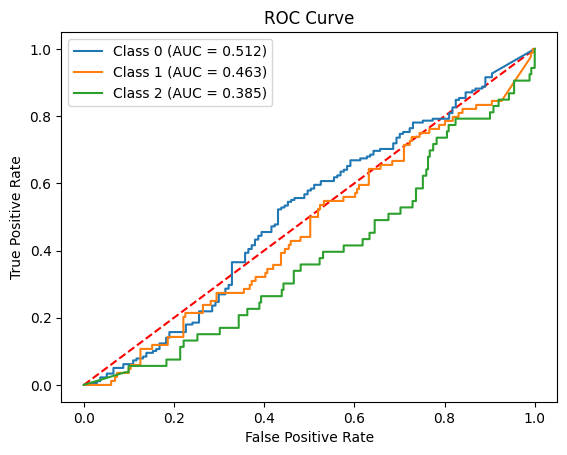

In [13]:
plt.plot([0, 1], [0, 1], 'r--')
for i in range(n_classes):
    plt.plot(false_positive_rate[i], true_positive_rate[i], label='Class {} (AUC = {:.3f})'.format(i, area_under_curve[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


1/1 [==============================] - 0s 27ms/step


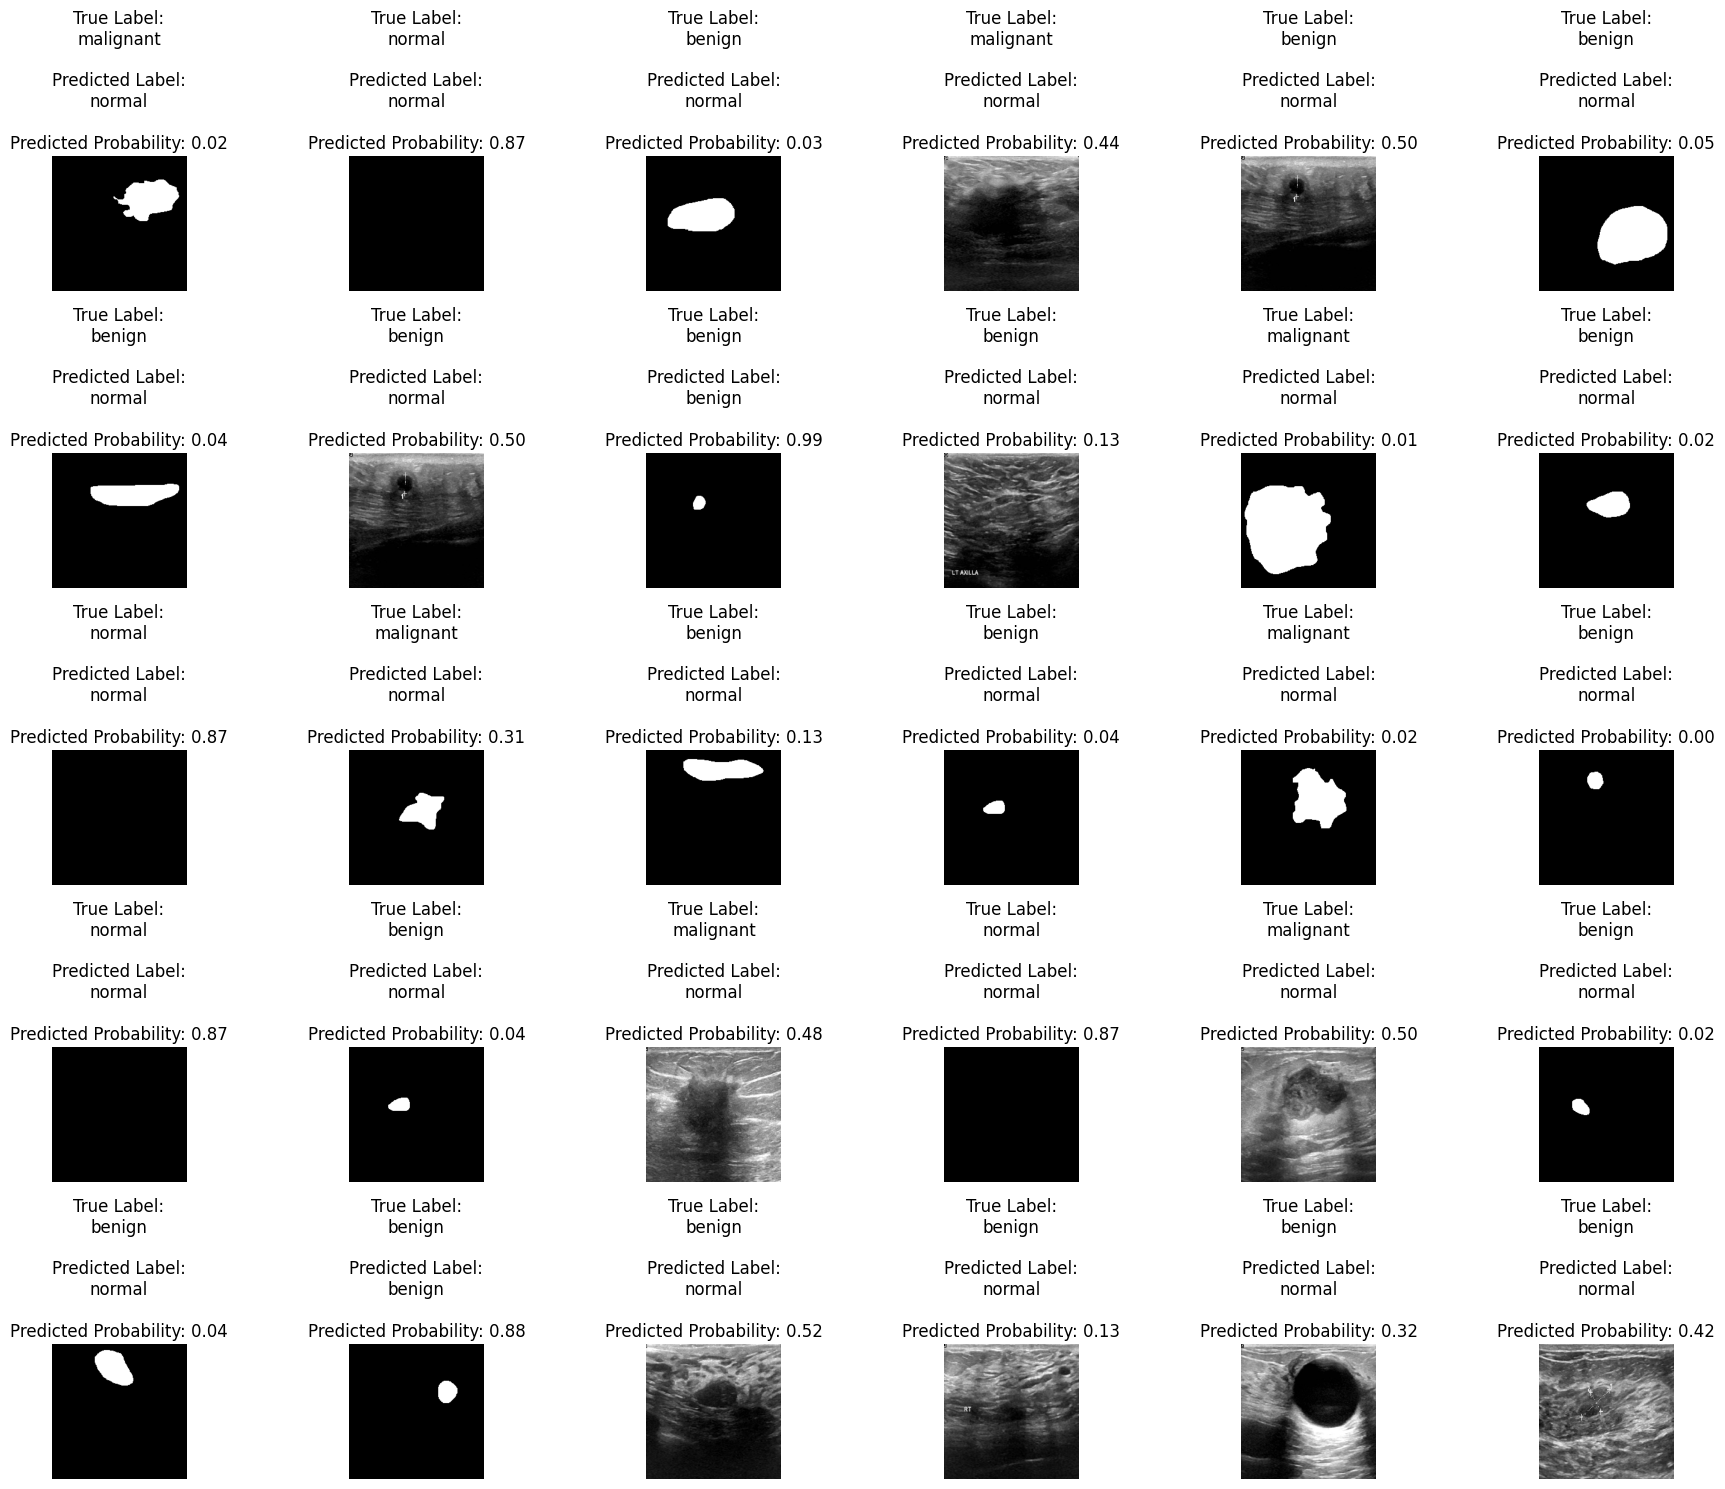

In [17]:
def visualize_images_in_pairs(num_image_pairs, data_generator, model):
    # 무작위 이미지 페어 인덱스 생성
    random_indexes = [random.randint(0, len(data_generator) - 1) for _ in range(num_image_pairs)]

    # 5행 x 6열의 subplot을 가지는 figure 생성
    num_rows = 5
    num_cols = 6
    plt.figure(figsize=(18, 15))  # 큰 사이즈로 설정

    for i, image_index in enumerate(random_indexes):
        plt.subplot(num_rows, num_cols, i + 1)

        selected_image, true_label = data_generator[image_index]

        # 이미지 예측
        predicted_probabilities = model.predict(selected_image)
        predicted_class = np.argmax(predicted_probabilities)

        # 클래스 레이블 매핑
        class_labels = {0: 'benign', 1: 'malignant', 2: 'normal'}

        true_label_index = np.argmax(true_label, axis=1)
        true_label_str = class_labels[true_label_index[0]]

        predicted_class = max(0, min(predicted_class, 2))
        predicted_label_str = class_labels[predicted_class]

        plt.imshow(selected_image[0])
        # 이미지와 글자 사이의 간격을 조절
        plt.title(f"True Label:\n{true_label_str}\n\nPredicted Label:\n{predicted_label_str}\n\nPredicted Probability: {predicted_probabilities[0][predicted_class]:.2f}")
        plt.axis('off')

# 30개의 이미지를 표시
visualize_images_in_pairs(30, train_data, model)
plt.tight_layout()  # 이미지와 글자 간격 조정
plt.show()
